The first block will import all necessary library and modules to run this code. Click on the button to toggle (show code).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
import cv2
import matplotlib as mpl
from skimage import color
from skimage import feature
from skimage import measure
from skimage.feature import hog
from skimage.filters import prewitt_h,prewitt_v
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.measure.entropy import shannon_entropy
from skimage.filters import prewitt
from sklearn import svm
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,accuracy_score
import sklearn.metrics as metrics
plt.close()

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

## Reading and viewing data

['792.tif', '556.tif', '380.tif', '1111.tif', '1275.tif']


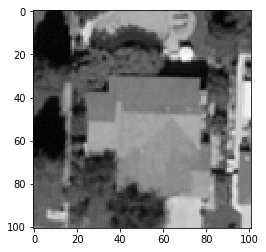

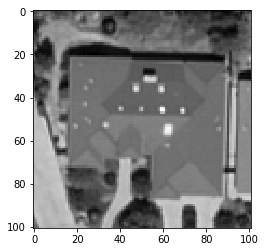

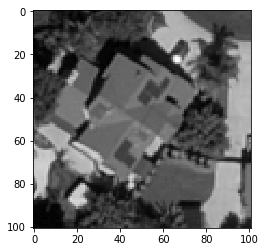

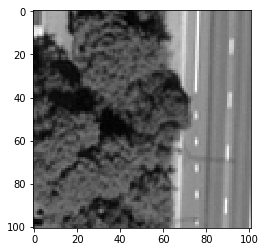

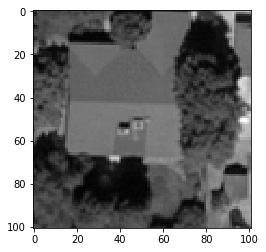

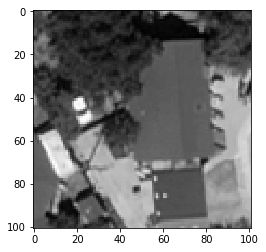

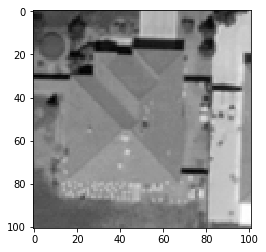

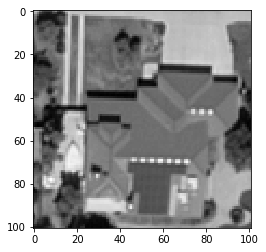

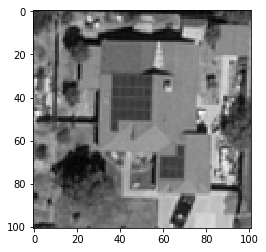

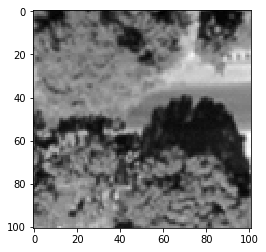

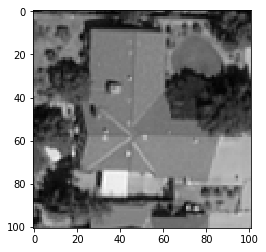

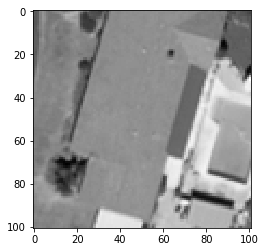

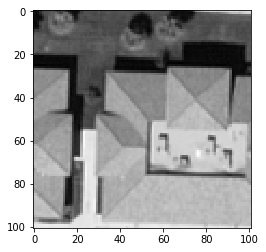

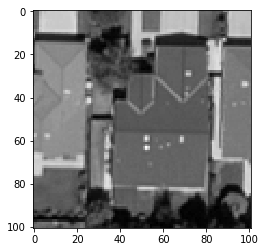

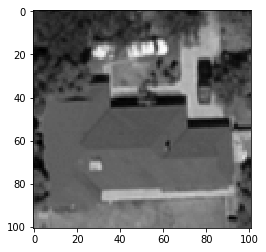

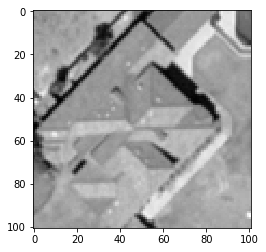

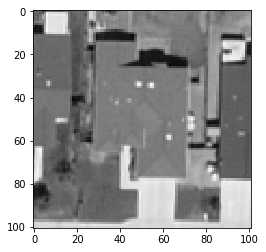

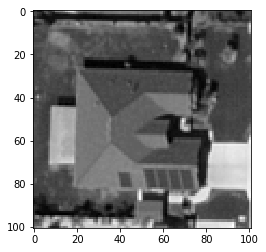

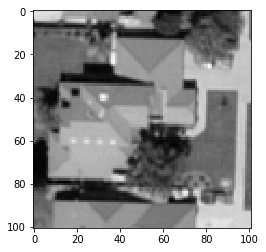

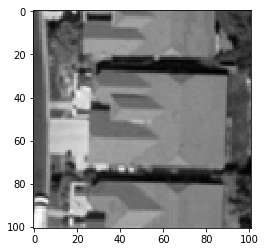

In [2]:

#I = plt.imread("/kaggle/input/ids705sp2020/training/1121.tif")


train_tiffs = os.listdir("/kaggle/input/ids705sp2020/training/")
print(train_tiffs[:5])

for tiff in train_tiffs[:20]:
    im = cv2.imread("/kaggle/input/ids705sp2020/training/" + tiff, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(im, cmap='gray')
    plt.show()

In [3]:
'''
Set directory parameters
'''
# Set the directories for the data and the CSV files that contain ids/labels
dir_train_images  = '../input/ids705sp2020/training/'
dir_test_images   = '../input/ids705sp2020/testing/'
dir_train_labels  = '../input/ids705sp2020/labels_training.csv'
dir_test_ids      = '../input/ids705sp2020/sample_submission.csv'

Below are a few functions that have been creates to perform some specific functions. The description of each function is mentioned in the code chunk below.

In [4]:
def load_data(dir_data, dir_labels, training=True):
    ''' Load each of the image files into memory 

    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory

    When training=True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.tif'
        image     = mpl.image.imread(fname)
        data.append(image)
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids

def preprocess_and_extract_features(data):
    '''Preprocess data and extract features
    
    Preprocess: normalize, scale, repair
    Extract features: transformations and dimensionality reduction
    '''
    # Here, we do something trivially simple: we take the average of the RGB
    # values to produce a grey image, transform that into a vector, then
    # extract the mean and standard deviation as features.
    
    # Make the image grayscale
    data = np.mean(data, axis=3)
    
    # Vectorize the grayscale matrices
    vectorized_data = data.reshape(data.shape[0],-1)
    
    # extract the mean and standard deviation of each sample as features
    feature_mean = np.mean(vectorized_data,axis=1)
    feature_std  = np.std(vectorized_data,axis=1)
    
    # Combine the extracted features into a single feature vector
    features = np.stack((feature_mean,feature_std),axis=-1)
    
    return features


def cv_performance_assessment(X,y,k,clf):
    '''Cross validated performance assessment
    
    X   = training data
    y   = training labels
    k   = number of folds for cross validation
    clf = classifier to use
    
    Divide the training data into k folds of training and validation data. 
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are 
    aggregated and output
    '''
    # Establish the k folds
    prediction_scores = np.empty(y.shape[0],dtype='object')
    kf = StratifiedKFold(n_splits=k, shuffle=True)
    i=1
    for train_index, val_index in kf.split(X, y):
        # Extract the training and validation data for this fold
        print('iteration:',i,",length:",len(train_index),"Train indices selected:",train_index)
        X_train, X_val   = X[train_index], X[val_index]
        y_train          = y[train_index]
        
        # Train the classifier
        clf              = clf.fit(X_train,y_train)
        
        # Test the classifier on the validation data for this fold
        cpred            = clf.predict_proba(X_val)
        
        # Save the predictions for this fold
        prediction_scores[val_index] = cpred[:,1]
        i=i+1
    return prediction_scores

def plot_roc(labels, prediction_scores):
    '''Obtain the true positive rate, false positive rate and plot ROC curve for a classifier
    
    Input for the function is the ground truth and the predicted probability scores
    AUC will computed using these arguments
    Chance curve is also shown to compare the performance of your classifier
    '''
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_scores, pos_label=1)
    auc = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = 'AUC = {:0.3f}'.format(auc)
   
    plt.plot([0,1],[0,1],'--', color='gray', label='Chance')
    plt.plot(fpr, tpr, label=legend_string)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.axis('square')
    plt.legend()
    plt.tight_layout()
    
def plot_prec_recall(labels, prediction_scores):
    '''Plot Precision Recall curve for a classifier
    
    Input for the function is the ground truth and the predicted probability scores
    The majority class predictor is also shown to compare the performance of your classifier to baseline
    '''
    # for your classifier
    precision, recall, _ = metrics.precision_recall_curve(labels, prediction_scores, pos_label=1)
    plt.step(recall,precision,label="classifier")

    # for a classifier that predicts all 0-- majority class
    zero_preds= np.zeros(labels.shape)
    precision2, recall2, _ = metrics.precision_recall_curve(labels, zero_preds, pos_label=1)
    plt.plot(recall2,precision2,'--o',color='grey',label="zero class predictor")
    
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.title('Precision Recall curve')
    plt.tight_layout()

In [5]:
# Load the training data
data, labels = load_data(dir_train_images, dir_train_labels, training=True)
# storing train_ids in an array
train_ids= pd.read_csv('../input/ids705sp2020/labels_training.csv')
train_ids=np.array(train_ids['id'])

# Load the test data
test_data, ids = load_data(dir_test_images, dir_test_ids, training=False)

Below is a plot showing the distribution of observed data points in each class.

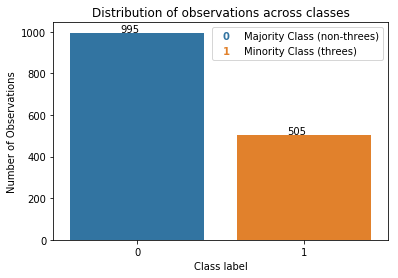

In [6]:
# bar chart of distribution of records across 2 classes
ax=sns.countplot(labels)
plt.title("Distribution of observations across classes")
plt.xlabel("Class label")
plt.ylabel("Number of Observations")


# class to add y-values as data labels on bar chart
class TextHandler(HandlerBase):
    def create_artists(self, legend, tup ,xdescent, ydescent,
                        width, height, fontsize,trans):
        tx = Text(width/2.,height/2,tup[0], fontsize=fontsize,
                  ha="center", va="center", color=tup[1], fontweight="bold")
        return [tx]

handltext = ["0", "1"]
#define labels to make more intuitive
labels_trans = ["Majority Class (non-threes)", "Minority Class (threes)"]


t = ax.get_xticklabels()
labeldic = dict(zip(handltext, labels_trans))
labels_trans = [labeldic[h.get_text()]  for h in t]
# creating handles for the legend
handles = [(h.get_text(),c.get_fc()) for h,c in zip(t,ax.patches)]

ax.legend(handles, labels_trans, handler_map={tuple : TextHandler()}) 
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+1))
plt.show()

We see that the majority class is class 0 (no solar panel). It has 995 data points. 

## Testing a Basic Model

We will first try the basic preprocessing steps provided in the sample code. This includes extracting the mean and standard deviation as features from grayscale images.

In [7]:
# run the preprocess_and_extract_features user-defined function and store it in an array for the model input.
training_features= preprocess_and_extract_features(data)

In [8]:
# try SVM with no parameters tuning
# predicting probability
clf= svm.SVC(probability=True)
clf.fit(training_features,labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

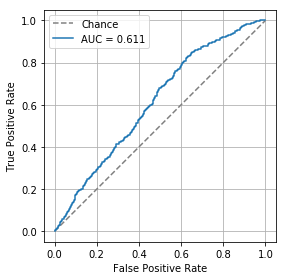

In [9]:
# obtaining train predictions using the fit model- to get baseline performance
train_preds    = clf.predict_proba(training_features)[:,1]
# get ROC curve
plot_roc(labels, train_preds)

Please note that this performance is the one obtained on the complete training set after the model was fit on that set. Thus, the performance looks like it is suboptimal

## Preprocessing and Feature Extraction

Text(0.5, 1.0, 'Sample image in true form')

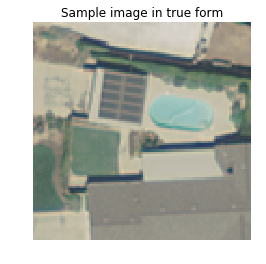

In [10]:
plt.imshow(data[3])
plt.axis('off')
plt.title('Sample image in true form')

### Converting images to Grayscale

In [11]:
# using Luminance to obtain grayscale images
# luminance is the weighted average of RGB values
data_gray = [ color.rgb2gray(i) for i in data]

Text(0.5, 1.0, 'Sample output from the grayscaling')

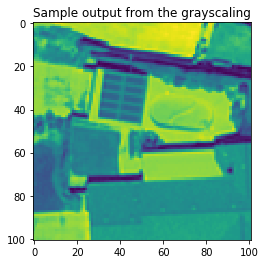

In [12]:
plt.imshow(data_gray[3])
plt.title('Sample output from the grayscaling')

Text(0.5, 1.0, 'Sample output from the grayscaling in cmap="grayscale"')

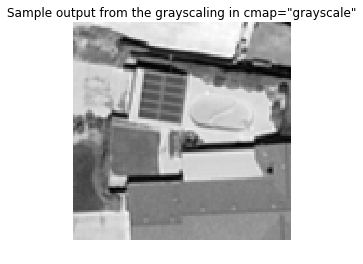

In [13]:
plt.imshow(data_gray[3], cmap='gray')
plt.axis('off')
plt.title('Sample output from the grayscaling in cmap="grayscale"')

Text(0.5, 0.98, 'Examples of ground truth (class 1) misclassified as Class 0 by LightGBM')

<Figure size 1440x1080 with 0 Axes>

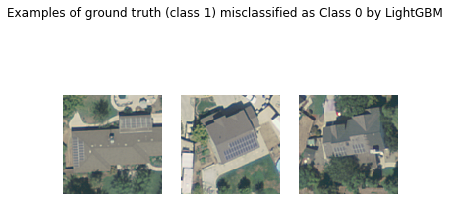

In [14]:
fig=plt.figure(figsize=(20, 15))
fig, ax = plt.subplots(1,3)
ax[0].imshow(data[24])
ax[0].axis('off')
ax[1].imshow(data[37])
ax[1].axis('off')
ax[2].imshow(data[148])
ax[2].axis('off')
plt.suptitle("Examples of ground truth (class 1) misclassified as Class 0 by LightGBM")

Text(0.5, 0.98, 'Examples of ground truth (class 0) misclassified as Class 1 by LightGBM')

<Figure size 1440x1080 with 0 Axes>

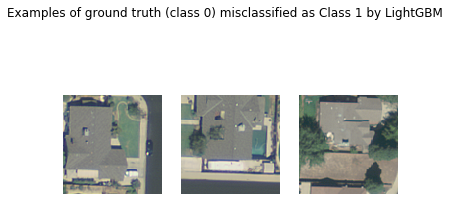

In [15]:
fig=plt.figure(figsize=(20, 15))
fig, ax = plt.subplots(1,3)
ax[0].imshow(data[766])
ax[0].axis('off')
ax[1].imshow(data[1173])
ax[1].axis('off')
ax[2].imshow(data[336])
ax[2].axis('off')
plt.suptitle("Examples of ground truth (class 0) misclassified as Class 1 by LightGBM")

### HOG (Histogram of Oriented Gradient) transformation

In [16]:
ppc = 16
hog_images = []
hog_features = []
for image in data_gray:
    # extracting hog transformed images and the feature arrays
    fd,hog_image = hog(image, orientations=10, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

In [17]:
len(hog_features)

1500

This is an array of 1500 feature arrays i.e. 1 for each image

Text(0.5, 1.0, 'Image after applying HOG filter')

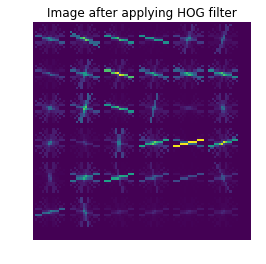

In [18]:
# plot image after applying HOG filter to grayscale image
plt.imshow(hog_images[3])
plt.axis('off')
plt.title('Image after applying HOG filter')

### Horizontal and vertical edges

In [19]:
hor_edges = []
ver_edges = []
for image in data_gray:
    #calculating horizontal edges using prewitt kernel
    edges_prewitt_horizontal = prewitt_h(image)
    #calculating vertical edges using prewitt kernel
    edges_prewitt_vertical = prewitt_v(image)
    hor_edges.append(edges_prewitt_horizontal)
    ver_edges.append(edges_prewitt_vertical)

In [20]:
len(ver_edges)

1500

Text(0.5, 1.0, 'Image after applying vertical edge detector')

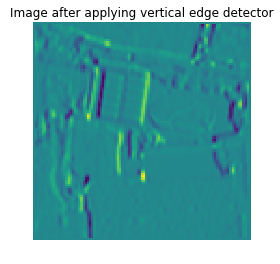

In [21]:
# plot image after applying vertical edge filter to grayscale image
plt.imshow(ver_edges[3])
plt.axis('off')
plt.title('Image after applying vertical edge detector')

We will not be using this as is as no feasible feature arrays are coming out of it. We will check for canny edge detections

### Canny Edge Detections

In [22]:
canny_edges = []
for image in data_gray:
    # obtain canny detector applied images
    edges_sigma1 = feature.canny(image, sigma=3)
    # averaging the canny edge applied image by its size to obtain a feature
    apw = (float(np.sum(edges_sigma1)) / (image.size))
    canny_edges.append(apw)
    
len(canny_edges)

1500

The Canny filter is a multi-stage edge detector. It uses a filter based on the derivative of a Gaussian in order to compute the intensity of the gradients.The Gaussian reduces the effect of noise present in the image. Then, potential edges are thinned down to 1-pixel curves by removing non-maximum pixels of the gradient magnitude. Finally, edge pixels are kept or removed using hysteresis thresholding on the gradient magnitude.

The Canny has three adjustable parameters: the width of the Gaussian (the noisier the image, the greater the width), and the low and high threshold for the hysteresis thresholding.

Source: [skimage canny](https://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html)

In [23]:
canny_edges_for_image = []
for image in data_gray:
    # running this bit to get the images after canny edge detector is applied- to visualize
    edges_sigma1 = feature.canny(image, sigma=3)
    canny_edges_for_image.append(edges_sigma1)
    
len(canny_edges_for_image)

1500

Text(0.5, 1.0, 'Image after applying Canny Edge Detector')

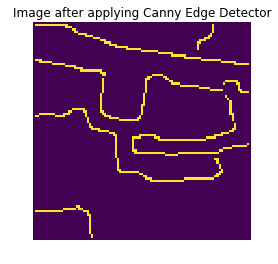

In [24]:
# plot image after applying canny edge detector to grayscale image
plt.imshow(canny_edges_for_image[3])
plt.axis('off')
plt.title('Image after applying Canny Edge Detector')

### Entropy filter (and Shannon Entropy)

In [25]:
shannon_entr = []
for image in data_gray:
    #calculating shannon entropy (proprtional to -log(pk) where pk= probability of a pixel with intensity k)
    shannon_e1 = shannon_entropy(image)
    shannon_entr.append(shannon_e1)
    
len(shannon_entr)

1500

The information entropy is the log-base-2 of the number of possible outcomes for a message.

For an image, local entropy is related to the complexity contained in a given neighborhood, typically defined by a structuring element. The entropy filter can detect subtle variations in the local gray level distribution.

Source: [skimage entropy](https://scikit-image.org/docs/dev/auto_examples/filters/plot_entropy.html)

In [26]:
entropies = []
for image in data_gray:
    #getting images with entropy filter applied to the images
    e1 =entropy(image, disk(10))
    entropies.append(e1)
    
len(entropies)

/opt/conda/lib/python3.6/site-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


1500

Text(0.5, 1.0, 'Image after applying entropy filter')

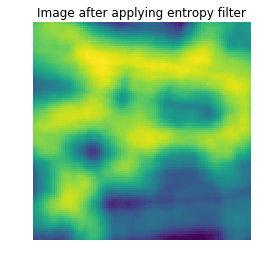

In [27]:
# plot image after applying entropy filter to grayscale image
plt.imshow(entropies[3])
plt.axis('off')
plt.title('Image after applying entropy filter')

Text(0.5, 1.0, 'Image after applying entropy filter')

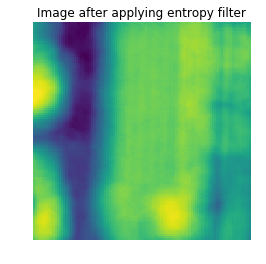

In [28]:
# checking the same image for im ID 1399
plt.imshow(entropies[1399])
plt.axis('off')
plt.title('Image after applying entropy filter')

We will use shannon entropy of each image as a feature for the same.

### Moments of an image

An image moment is a certain particular weighted average (moment) of the image pixels' intensities, or a function of such moments, usually chosen to have some attractive property or interpretation.

Centroid= {x,y}= {M10/M00, M01/M00}

Source: [Wiki](https://en.wikipedia.org/wiki/Image_moment)

In [29]:
centroids = []
for image in data_gray:
    moment1 = measure.moments(image, order=3)
    centroid= np.array([(moment1[1, 0] / moment1[0, 0]), (moment1[0, 1] / moment1[0, 0])])
    #print(centroid)
    centroids.append(centroid)
    
len(centroids)

1500

We tried the feature in our model to see if it helps. We opted against it as it decreased the AUC

### Stacking features to create complete Feature set

In [30]:
#changing data type and structure to meet dimension requirements for the model
hog_features = np.array(hog_features)
centroids = np.array(centroids) # will not be using it
shannon_entr=np.array(shannon_entr).reshape(len(shannon_entr),1)
canny_edges=np.array(canny_edges).reshape(len(canny_edges),1)

In [31]:
# reshaping labels to meet dimension requirements
labels=labels.reshape(len(labels),1)
labels

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [1]])

In [32]:
# stacking feature sets

#features= np.hstack((hog_features,centroids,shannon_entr,canny_edges))
features= np.hstack((hog_features,shannon_entr,canny_edges))
features.shape

(1500, 1442)

In [33]:
# creating a data structure with both features and lables
data_frame = np.hstack((features,labels))

In [34]:
# making a 80-20% split for train test analysis:
split = 80
partition = int(len(features)*split/100)
# X and Y train and test
x_train, x_test = data_frame[:partition,:-1],  data_frame[partition:,:-1]
y_train, y_test = data_frame[:partition,-1:].ravel() , data_frame[partition:,-1:].ravel()

In [35]:
# will use these for inputs- had created shuffled version initially to check for performance of model
# now using input without shuffling
shuffled_Xs=data_frame[:,:-1]
shuffled_labels=data_frame[:,-1:].ravel()

### SVM

Creating an SVM model using new features and revised hyperparameters

In [36]:
#create classifier
clf = svm.SVC(C=0.2,kernel='poly',gamma='auto',probability=True)
# regularization: 0.2
# kernel for the algorithm= 'poly'
# kernel coefficient for 'poly': 'auto' uses 1 / n_features as coefficient

In [37]:
# fit on train
clf.fit(x_train,y_train)

SVC(C=0.2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [38]:
# predict probabilities on x_test
y_pred = clf.predict_proba(x_test)
pred_classes=np.where(y_pred[:,1]>0.5, 1, 0) # class predictions with threshold=0.5

# performance metrics on test data
print("Accuracy: "+str(accuracy_score(y_test, pred_classes)))
print('\n')
print(classification_report(y_test, pred_classes))

Accuracy: 0.6233333333333333


              precision    recall  f1-score   support

         0.0       0.87      0.49      0.63       195
         1.0       0.48      0.87      0.62       105

    accuracy                           0.62       300
   macro avg       0.68      0.68      0.62       300
weighted avg       0.73      0.62      0.63       300



Text(0.5, 1.0, 'ROC curve on 20% test dataset')

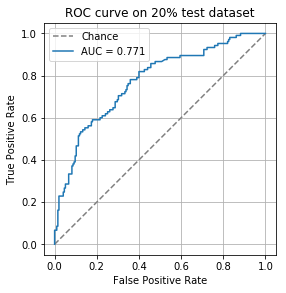

In [39]:
# ROC curve on test prediction
plot_roc(y_test, y_pred[:,1])
plt.title("ROC curve on 20% test dataset")

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Text(0.5, 1.0, 'Precision Recall curve on 20% test dataset')

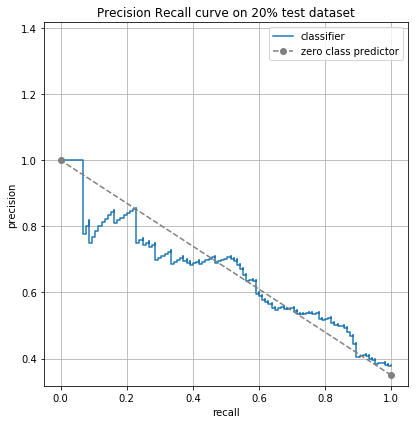

In [40]:
# precision recall curve
fig = plt.figure(figsize=(6, 6))
  
# Compute and plot the ROC curves
plot_prec_recall(y_test, y_pred[:,1])
plt.title("Precision Recall curve on 20% test dataset")

In [41]:
# predict probabilities on x_train
train_pred = clf.predict_proba(x_train)
pred_classes=np.where(train_pred[:,1]>0.5, 1, 0) # class predictions with threshold=0.5

# performance metrics on training data
print("Accuracy: "+str(accuracy_score(y_train, pred_classes)))
print('\n')
print(classification_report(y_train, pred_classes))

Accuracy: 0.6591666666666667


              precision    recall  f1-score   support

         0.0       0.91      0.54      0.68       800
         1.0       0.49      0.89      0.64       400

    accuracy                           0.66      1200
   macro avg       0.70      0.72      0.66      1200
weighted avg       0.77      0.66      0.67      1200



Text(0.5, 1.0, 'ROC curve on 80% training dataset')

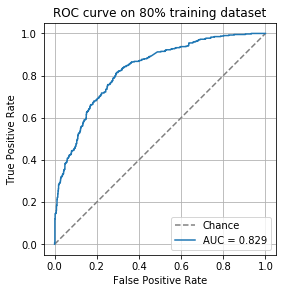

In [42]:
# ROC curve on train prediction
plot_roc(y_train, train_pred[:,1])
plt.title("ROC curve on 80% training dataset")

We will now fit the model on the complete dataset. If chosen, this model fit will be used as we need to train the data on all the available observed points.

In [43]:
# fit clf on all data points
clf.fit(shuffled_Xs,shuffled_labels)

SVC(C=0.2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Text(0.5, 1.0, 'ROC curve on complete training dataset')

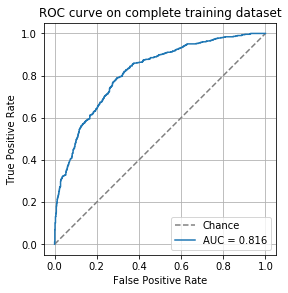

In [44]:
# use fit model to predict on complete datasets
y_pred_svm_total = clf.predict_proba(shuffled_Xs)[:,1]
# ROC curve on complete training data
plot_roc(shuffled_labels, y_pred_svm_total)
plt.title("ROC curve on complete training dataset")

In [45]:
# saving predictions on training file to a csv
training_pred_file_svm = pd.DataFrame({'id':    train_ids,
                                   'score':  y_pred_svm_total})
training_pred_file_svm.to_csv('train_preds_svm.csv',
                           columns=['id','score'],
                           index=False)

#### Checking baseline with Naive Bayes

In [46]:
# applying Gaussian Naive Bayes to get the baselineperformance of transformed features
cross_val_score(GaussianNB(), x_train,y_train)

array([0.64583333, 0.68333333, 0.60833333, 0.64166667, 0.57916667])

The SVM model performs better than a Naive Bayes baseline classifier. We will try to improve the performance using a tree-based classifier. Let us try LightGBM due to the high dimensionality and size of the dataset

### Light GBM

We will strat with creating a classifier- to create & tune the model, we will manually iterate to find the best fit (in terms of the AUC). We will use cross validation to assess the performance of the model and not tune it.

In [47]:
#create LGBM classifier model
gbm_model = lgb.LGBMClassifier(
        boosting_type= "dart",
        n_estimators=1800,
        learning_rate=0.1,
        num_leaves=35,
        colsample_bytree=.8,
        subsample=.9,
        max_depth=9,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01
)

# learning rate= 0.1
# number of estimators: 1800
# boosting algorithm: 'dart'

#### 10-fold cross validation

Below is the chunk of code for applying 10-fold cross validation. The function for the same has been created above.

In [48]:
num_training_folds = 10
# get cross validated scores
# split is 999-501 with 999 images in training set
cv_prediction_scores = cv_performance_assessment(shuffled_Xs,shuffled_labels,num_training_folds,gbm_model)

iteration: 1 ,length: 1350 Train indices selected: [   0    1    2 ... 1497 1498 1499]
iteration: 2 ,length: 1350 Train indices selected: [   0    1    2 ... 1496 1497 1499]
iteration: 3 ,length: 1350 Train indices selected: [   0    1    2 ... 1497 1498 1499]
iteration: 4 ,length: 1350 Train indices selected: [   0    1    2 ... 1497 1498 1499]
iteration: 5 ,length: 1350 Train indices selected: [   0    1    3 ... 1497 1498 1499]
iteration: 6 ,length: 1350 Train indices selected: [   0    1    2 ... 1497 1498 1499]
iteration: 7 ,length: 1350 Train indices selected: [   0    1    2 ... 1495 1496 1498]
iteration: 8 ,length: 1350 Train indices selected: [   1    2    3 ... 1497 1498 1499]
iteration: 9 ,length: 1350 Train indices selected: [   0    2    3 ... 1497 1498 1499]
iteration: 10 ,length: 1350 Train indices selected: [   0    1    2 ... 1497 1498 1499]


Text(0.5, 1.0, 'ROC curve from 10-fold cross validation')

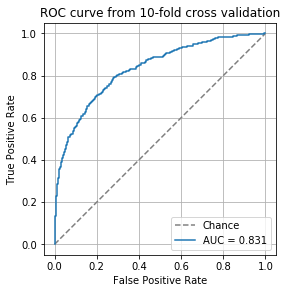

In [49]:
# Compute and plot the ROC curves
plot_roc(shuffled_labels, cv_prediction_scores)
plt.title("ROC curve from 10-fold cross validation")

In [50]:
# save CV predictions in a csv file
cv_pred_file = pd.DataFrame({'id':    train_ids,
                                   'true_labels':  shuffled_labels,
                                      'cv_predictions':cv_prediction_scores})
cv_pred_file.to_csv('cv_preds.csv',
                           columns=['id','true_labels','cv_predictions'],
                           index=False)

In [51]:
#fit the LGBM model on training data- created earlier with 80-20% split
gbm_model=gbm_model.fit(x_train,y_train,verbose=0)

Text(0.5, 1.0, 'ROC curve on 20% test split')

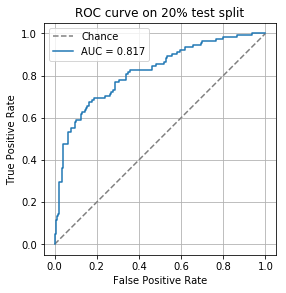

In [52]:
# predict probabilities on test set
y_pred_gbm = gbm_model.predict_proba(x_test)
plot_roc(y_test, y_pred_gbm[:,1])
plt.title("ROC curve on 20% test split")

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Text(0.5, 1.0, 'Precision Recall curve on 20% test split')

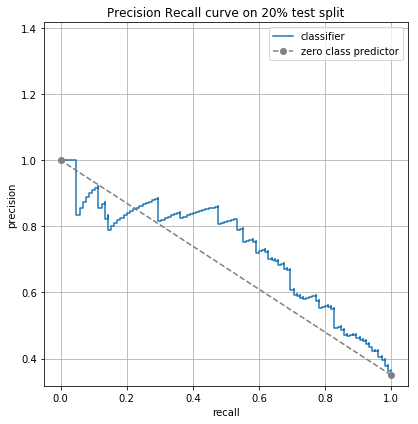

In [53]:
fig = plt.figure(figsize=(6, 6))
  
# Compute and plot the ROC curves
plot_prec_recall(y_test, y_pred_gbm[:,1])
plt.title("Precision Recall curve on 20% test split")

We will now fit the model on the complete 1500 training set.

In [54]:
# fit model on 1500 observed images
gbm_model=gbm_model.fit(shuffled_Xs,shuffled_labels,verbose=0)

In [55]:
# prediction on complete training dataset
y_pred_gbm_total = gbm_model.predict_proba(shuffled_Xs)[:,1]

In [56]:
# save the predictions in a csv file
training_pred_file_lgb = pd.DataFrame({'id':    train_ids,
                                   'score':  y_pred_gbm_total})
training_pred_file_lgb.to_csv('train_preds_lgb.csv',
                           columns=['id','score'],
                           index=False)

We will use the LGBM model for our baseline model in the final report.

## Final Test

In this section, we will conduct all the feature transformation steps on the test dataset. We will then used the LGBM model to predict and then submit the prediction files using the results thus obtained.

### Grayscale

In [57]:
# convert images to grayscale
test_data_gray = [ color.rgb2gray(i) for i in test_data]

### HOG filter

In [58]:
hog_images_test = []
hog_features_test = []
for image in test_data_gray:
    fd,hog_image = hog(image, orientations=10, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
    hog_images_test.append(hog_image)
    # obtaining HOG features for model
    hog_features_test.append(fd)

### Shannon Entropy

In [59]:
shannon_entr_test = []
for image in test_data_gray:
    #calculating shannon entropy as a feature
    shannon_e1 = shannon_entropy(image)
    shannon_entr_test.append(shannon_e1)
    
len(shannon_entr_test)

558

### Canny edge detector

In [60]:
canny_edges_test = []
for image in test_data_gray:
    # using averaged canny edge detector output as a feature
    edges_sigma1 = feature.canny(image, sigma=3)
    apw = (float(np.sum(edges_sigma1)) / (image.size))
    canny_edges_test.append(apw)
    
len(canny_edges_test)

558

### Stacking features 

In [61]:
hog_features_test = np.array(hog_features_test)
shannon_entr_test=np.array(shannon_entr_test).reshape(len(shannon_entr_test),1)
canny_edges_test=np.array(canny_edges_test).reshape(len(canny_edges_test),1)

The features thus obtained have been transformed to meet the data structure and dimension requirements of the model. We will stack it now and feed it to the model.

In [62]:
# stacking features to create complete test feature stck
features_test= np.hstack((hog_features_test,shannon_entr_test,canny_edges_test))

### Model Predictions

In [63]:
# predictions from SVM model
test_predictions_svm=clf.predict_proba(features_test)[:,1]

In [64]:
# predictions from LGBM
test_predictions_lgb = gbm_model.predict_proba(features_test)[:,1]

In [65]:
# saving both predictions to CSV files
submission_file_svm = pd.DataFrame({'id':    ids,
                                   'score':  test_predictions_svm})
submission_file_svm.to_csv('submission_svm.csv',
                           columns=['id','score'],
                           index=False)

submission_file_lgbm = pd.DataFrame({'id':    ids,
                                   'score':  test_predictions_lgb})
submission_file_lgbm.to_csv('submission_lgbm.csv',
                           columns=['id','score'],
                           index=False)

The complete notebook has been run and the results can be found [here](https://www.kaggle.com/srishti280992/solar-panel)

In [66]:
!pip install nbconvert  
!apt install pandoc
!jupyter nbconvert --execute --to html __notebook_source__.ipynb




pandoc is already the newest version (1.17.2~dfsg-3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
[NbConvertApp] WARNING | pattern '__notebook_source__.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--debug
    set log level to logging.DEBUG (maximize logging output)
--generate-config
    generate default config file
-y
    Answer yes to any questions instead of prompting.
--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--stdin
    read a single note